In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Import need packages

In [2]:
import sys
# Add Python Tools
pythonToolsDir = r'J:\Projects\JHUTrabeculae\Software\Python\PythonTools'
sys.path.append(pythonToolsDir)

# Add ctk-cli
ctkcli_DIR = r'J:\Projects\JHUTrabeculae\Software\Python\ctk-cli'
sys.path.append(ctkcli_DIR)

# Add TrabeculaeTools
TrabeculaeTools_DIR = r'J:\Projects\JHUTrabeculae\Software\Python\TrabeculaeTools'
sys.path.append(TrabeculaeTools_DIR)

from PythonTools.helpers.elastix import elastix as elastixhelper
from PythonTools import io, transformations
from ImageJTools import macroImageJ
from ImageJTools.HelperBoneJ import *
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D

## Set need programs

In [3]:
# Elastix registration
elastixPath = r'J:\Projects\JHUTrabeculae\Software\Programs\elastix\elastix.exe'

# Path to imageJ (Need BoneJ and NII reader plugins)
imagej_exe_path = r'J:\Projects\JHUTrabeculae\Software\Programs\Fiji\ImageJ-win64.exe'

# Macro definition for segmentation Trabeculae
SegmentfileXMLdescription = r'J:\Projects\JHUTrabeculae\Software\Python\TrabeculaeTools\ImageJMacros\SegmentTrabeculaImageJMacro.xml'
SegmentmacroPath = r'J:\Projects\JHUTrabeculae\Software\Python\TrabeculaeTools\ImageJMacros\SegmentTrabeculaImageJMacro.ijm'

# Macro definition for Metric Trabeculae
MetricfileXMLdescription = r'J:\Projects\JHUTrabeculae\Software\Python\TrabeculaeTools\ImageJMacros\BoneJMetricsImageJMacro.xml'
MetricmacroPath = r'J:\Projects\JHUTrabeculae\Software\Python\TrabeculaeTools\ImageJMacros\BoneJMetricsImageJMacro.ijm'

In [4]:
# To do it repetible
RandomSeed = 32

# Size of RoIs that will be studied in mm
RoISizeVector = [4.5]

# Number of RoIs that will be generated for each RoI Size
NRandomRoIs = 50

## Define the images for analysis and parameters for the study

### Data Folder Structure
- :open_file_folder: studyPath
  - :file_folder: Originals
    - :page_with_curl: CBCT.nii (Target image of CBCT)
    - :page_with_curl: uCT.nii (Source image of uCT)
    - :page_with_curl: CBCT_BoneMask.nii (Total Bone Segmentation of CBCT image)
  - :file_folder: Registration
    - :page_with_curl: RegistrationParams.txt (elastix parameters for registration)



In [5]:
# Path for analysis
studyPath = r'J:\Projects\JHUTrabeculae\Results\uCTVsCMOSvsFlatpanel'

# Starting Folders
originalsFolder = studyPath + r'\Originals'
registrationFolder = studyPath + r'\Registration'

# Original Images for analysis
CBCTimagePath = originalsFolder + r'\CBCT.nii'
uCTimagePath  = originalsFolder + r'\uCT.nii'
CMOSimagePath  = originalsFolder + r'\CMOS.nii'
FlatPanelimagePath  = originalsFolder + r'\FlatPanel.nii'

# Total Bone of CBCT image
BoneCBCTimagePath = originalsFolder + r'\CBCT_BoneMask.nii'

# Folder For RoI results
RoiFolder = studyPath + r'\RoIFiles'

# 1. Preregistration

In order to help registration performance, we first semi align the images using Slicer. The transformation will be saved as a *.tmf file into Registration folder using the name "InitialTransform.tfm"

In [6]:
# Perform the initial registration for image flips
InitialTransformFlatPanel = registrationFolder + r'\FlatPannel2CBCT.tfm'
InitialTransformCMOS = registrationFolder + r'\CMOS2CBCT.tfm'

# 2. Perform Registration

Usually, uCT image is quite big and memory cannot handle it. To facilitate the registration process, we create a downsampled version of uCT. This image will be registered to the actual CBCT image and registration parameters will be saved for further use.

In [7]:
registrationParametersPath = registrationFolder + r'\Registrationparams.txt'

   ## 2.1 Downsampling

In [8]:
DownsamplingFactor = 3
DownsampleduCTimagePath = registrationFolder + r'\uCTDownsampled.nii'

# This uses Linear Interpolation. BsplineInterpolator cannot handle the resampling.
DownsampleImage(uCTimagePath,DownsampleduCTimagePath,DownsamplingFactor)

[22.57 s]    - Downsampling...
[54.96 s]    - Finished!


 ## 2.2 Registration

In [11]:
# Registration CMOS

# Transform Initial Transform to elastix format
InitialTransformElastixCMOS = registrationFolder + r'\InitialTransformCMOS.txt'
elastixhelper.itk2elastix(InitialTransformCMOS,InitialTransformElastixCMOS)

# Launch Registration
cmdString = elastixPath + \
            ' -f ' + CBCTimagePath + \
            ' -m ' + CMOSimagePath + \
            ' -p ' + registrationParametersPath + \
            ' -t0 ' + InitialTransformElastixCMOS + \
            ' -out '+ registrationFolder + \
            ' -threads 4'
# Launch Registration
launchCMD(cmdString)

# Join Transformation and create final transformation
RegistrationTransformElastix = registrationFolder + r'\TransformParameters.0.txt'
RegistrationTransform = registrationFolder + r'\TransformParametersCMOS.tfm'
elastixhelper.elastix2itk(RegistrationTransformElastix,RegistrationTransform)

# Compose Initial and Registration transformation
RegistrationTransformFinalCMOS = registrationFolder + r'\RegistrationTransformFinalCMOS.tfm'

Tinitial = io.load_tfm(InitialTransformCMOS)
TReg = io.load_tfm(RegistrationTransform)
TRegistrationComplete = transformations.concatenate_matrices(TReg, Tinitial)

io.save_tfm(RegistrationTransformFinalCMOS,TRegistrationComplete)

J:\Projects\JHUTrabeculae\Software\Programs\elastix\elastix.exe -f J:\Projects\JHUTrabeculae\Results\uCTVsCMOSvsFlatpanel\Originals\CBCT.nii -m J:\Projects\JHUTrabeculae\Results\uCTVsCMOSvsFlatpanel\Originals\CMOS.nii -p J:\Projects\JHUTrabeculae\Results\uCTVsCMOSvsFlatpanel\Registration\Registrationparams.txt -t0 J:\Projects\JHUTrabeculae\Results\uCTVsCMOSvsFlatpanel\Registration\InitialTransformCMOS.txt -out J:\Projects\JHUTrabeculae\Results\uCTVsCMOSvsFlatpanel\Registration -threads 4


In [12]:
# Registration uCT

# Transform Initial Transform to elastix format 
InitialTransformElastix = registrationFolder + r'\InitialTransform.txt'
elastixhelper.itk2elastix(InitialTransform,InitialTransformElastix)

# Launch Registration
cmdString = elastixPath + \
            ' -f ' + CBCTimagePath + \
            ' -m ' + DownsampleduCTimagePath + \
            ' -p ' + registrationParametersPath + \
            ' -t0 ' + InitialTransformElastix + \
            ' -out '+ registrationFolder + \
            ' -threads 4'
# Launch Registration
launchCMD(cmdString)

# Join Transformation and create final transformation
RegistrationTransformElastix = registrationFolder + r'\TransformParameters.0.txt'
RegistrationTransform = registrationFolder + r'\TransformParameters.tfm'
elastixhelper.elastix2itk(RegistrationTransformElastix,RegistrationTransform)

# Compose Initial and Registration transformation
RegistrationTransformFinal = registrationFolder + r'\RegistrationTransformFinal.tfm'

Tinitial = io.load_tfm(InitialTransform)
TReg = io.load_tfm(RegistrationTransform)
TRegistrationComplete = transformations.concatenate_matrices(TReg, Tinitial)

io.save_tfm(RegistrationTransformFinal,TRegistrationComplete)

In [14]:
# Registration FlatPanel

# Transform Initial Transform to elastix format
InitialTransformElastixFlatPanel = registrationFolder + r'\InitialTransformFlatPanel.txt'
elastixhelper.itk2elastix(InitialTransformFlatPanel,InitialTransformElastixFlatPanel)

# Launch Registration
cmdString = elastixPath + \
            ' -f ' + CBCTimagePath + \
            ' -m ' + FlatPanelimagePath + \
            ' -p ' + registrationParametersPath + \
            ' -t0 ' + InitialTransformElastixFlatPanel + \
            ' -out '+ registrationFolder + \
            ' -threads 4'
# Launch Registration
print cmdString
launchCMD(cmdString)

# Join Transformation and create final transformation
RegistrationTransformElastix = registrationFolder + r'\TransformParameters.0.txt'
RegistrationTransform = registrationFolder + r'\TransformParametersFlatPanel.tfm'
elastixhelper.elastix2itk(RegistrationTransformElastix,RegistrationTransform)

# Compose Initial and Registration transformation
RegistrationTransformFinalFlatPanel = registrationFolder + r'\RegistrationTransformFinalFlatPanel.tfm'

Tinitial = io.load_tfm(InitialTransformFlatPanel)
TReg = io.load_tfm(RegistrationTransform)
TRegistrationComplete = transformations.concatenate_matrices(TReg, Tinitial)

io.save_tfm(RegistrationTransformFinalFlatPanel,TRegistrationComplete)

J:\Projects\JHUTrabeculae\Software\Programs\elastix\elastix.exe -f J:\Projects\JHUTrabeculae\Results\uCTVsCMOSvsFlatpanel\Originals\CBCT.nii -m J:\Projects\JHUTrabeculae\Results\uCTVsCMOSvsFlatpanel\Originals\FlatPanel.nii -p J:\Projects\JHUTrabeculae\Results\uCTVsCMOSvsFlatpanel\Registration\Registrationparams.txt -t0 J:\Projects\JHUTrabeculae\Results\uCTVsCMOSvsFlatpanel\Registration\InitialTransformFlatPanel.txt -out J:\Projects\JHUTrabeculae\Results\uCTVsCMOSvsFlatpanel\Registration -threads 4


# 3. Generate RoI file for analysis

This file contains the RoI definition that will be analyzed for both images.

In [66]:
# Folder for RoI file save
#%reload_ext autoreload
CreateRoIfileStudy(BoneCBCTimagePath, RoiFolder, RoISizeVector, NRandomRoIs, RandomSeed, PrintDebug = False)


# Path To RoI
PathToRoIfile = RoiFolder + r'\RoIFileComplete.csv'

Creating RoI File: [19:06:11]--[||||||||||||||||||||] Finished!

# 4. Segmentation, Metric Analysis and Save Results

In [ ]:
# Path To RoI
PathToRoIfile = RoiFolder + r'\RoIFileComplete.csv'

# Read RoI definitions
RoIStructure = pd.read_csv(PathToRoIfile,index_col=0)
NumberOfRoIs = len(RoIStructure.index)

# Folder for results
ResultsDir = studyPath + r'\Results'
if not os.path.exists(ResultsDir):
    os.makedirs(ResultsDir)

# Temporal folder for results
MetricsOutputDir = studyPath + r'\MetricOutputTemp'
if not os.path.exists(MetricsOutputDir):
    os.makedirs(MetricsOutputDir)

percentage = 0
for i in range(NumberOfRoIs):
    RoIDefinition = RoIStructure.iloc[i]
    print RoIDefinition
    #####
    ##### ROI EXTRACTION
    #####
    try:
        # Extract RoI from CBCT
        PrintPercentage(percentage, preMessage = 'Extracting RoI from CBCT                             ')

        RoIFilePathCBCT = RoiFolder + '\\' + CBCTimagePath.split('\\')[-1][:-4] + '_{1:.2f}mm_RoI{0:d}.nii'.format(RoIDefinition['RoI Number'],RoIDefinition['RoI Size mm'])

        CreateRoI(  ImageFilePath = CBCTimagePath,\
                RoIDefinition = RoIDefinition,\
                RoIFilePath = RoIFilePathCBCT, \
                PrintDebug = False)

        # Extract RoI from uCT
        PrintPercentage(percentage, preMessage = 'Extracting RoI from uCT                              ')

        RoIFilePathuCT = RoiFolder + '\\' + uCTimagePath.split('\\')[-1][:-4] + '_{1:.2f}mm_RoI{0:d}.nii'.format(RoIDefinition['RoI Number'],RoIDefinition['RoI Size mm'])

        CreateRoITransformed(ImageFilePath = uCTimagePath,\
                         RoIDefinition = RoIDefinition,\
                         TransformationFile = RegistrationTransformFinal,\
                         ReferenceRoIImageFilePath = RoIFilePathCBCT,\
                         RoIFilePath = RoIFilePathuCT,\
                         PrintDebug = False)


        # Extract RoI from CMOS
        PrintPercentage(percentage, preMessage = 'Extracting RoI from CMOS                              ')

        RoIFilePathCMOS = RoiFolder + '\\' + CMOSimagePath.split('\\')[-1][:-4] + '_{1:.2f}mm_RoI{0:d}.nii'.format(RoIDefinition['RoI Number'],RoIDefinition['RoI Size mm'])

        CreateRoITransformed(ImageFilePath = CMOSimagePath,\
                             RoIDefinition = RoIDefinition,\
                             TransformationFile = RegistrationTransformFinalCMOS,\
                             ReferenceRoIImageFilePath = RoIFilePathCBCT,\
                             RoIFilePath = RoIFilePathCMOS,\
                             PrintDebug = False)

        # Extract RoI from FlatPanel
        PrintPercentage(percentage, preMessage = 'Extracting RoI from FlatPanel                              ')

        RoIFilePathFlatPanel = RoiFolder + '\\' + FlatPanelimagePath.split('\\')[-1][:-4] + '_{1:.2f}mm_RoI{0:d}.nii'.format(RoIDefinition['RoI Number'],RoIDefinition['RoI Size mm'])

        CreateRoITransformed(ImageFilePath = FlatPanelimagePath,\
                             RoIDefinition = RoIDefinition,\
                             TransformationFile = RegistrationTransformFinalFlatPanel,\
                             ReferenceRoIImageFilePath = RoIFilePathCBCT,\
                             RoIFilePath = RoIFilePathFlatPanel,\
                             PrintDebug = False)

        #####
        ##### ROI Segmentation
        #####


        # Segmentation for CBCT
        PrintPercentage(percentage, preMessage = 'Segmenting CBCT Using BoneJ                          ')

        RoIFilePathCBCTSegmented = RoiFolder + '\\' + CBCTimagePath.split('\\')[-1][:-4] + '_{1:.2f}mm_RoI{0:d}_SegmentedBoneJ.nii'.format(RoIDefinition['RoI Number'],RoIDefinition['RoI Size mm'])

        CBCTdataSegmentation = SegmentTrabeculaeBoneJ(  imagej_exe_path, SegmentmacroPath, SegmentfileXMLdescription, 
                                                    defaultTimeout = 700,\
                                                    PathToRoIfile = RoIFilePathCBCT,\
                                                    PathToSegmentedRoIfile = RoIFilePathCBCTSegmented,\
                                                    SMOOTH_Sigma = 0.03,\
                                                    TH_Erosion = 0,\
                                                    TH_Dilation = 0)

        # Segmentation for CBCT
        PrintPercentage(percentage, preMessage = 'Segmenting uCT Using BoneJ                           ')

        RoIFilePathuCTSegmented = RoiFolder + '\\' + uCTimagePath.split('\\')[-1][:-4] + '_{1:.2f}mm_RoI{0:d}_SegmentedBoneJ.nii'.format(RoIDefinition['RoI Number'],RoIDefinition['RoI Size mm'])

        uCTdataSegmentation = SegmentTrabeculaeBoneJ(  imagej_exe_path, SegmentmacroPath, SegmentfileXMLdescription, 
                                                    defaultTimeout = 700,\
                                                    PathToRoIfile = RoIFilePathuCT,\
                                                    PathToSegmentedRoIfile = RoIFilePathuCTSegmented,\
                                                    SMOOTH_Sigma = 0.03,\
                                                    TH_Erosion = 0,\
                                                    TH_Dilation = 0)

        # Segmentation for CMOS
        PrintPercentage(percentage, preMessage = 'Segmenting CMOS Using BoneJ                           ')

        RoIFilePathCMOSSegmented = RoiFolder + '\\' + CMOSimagePath.split('\\')[-1][:-4] + '_{1:.2f}mm_RoI{0:d}_SegmentedBoneJ.nii'.format(RoIDefinition['RoI Number'],RoIDefinition['RoI Size mm'])

        CMOSdataSegmentation = SegmentTrabeculaeBoneJ(  imagej_exe_path, SegmentmacroPath, SegmentfileXMLdescription, 
                                                    defaultTimeout = 700,\
                                                    PathToRoIfile = RoIFilePathCMOS,\
                                                    PathToSegmentedRoIfile = RoIFilePathCMOSSegmented,\
                                                    SMOOTH_Sigma = 0.03,\
                                                    TH_Erosion = 0,\
                                                    TH_Dilation = 0)


        # Segmentation for CMOS
        PrintPercentage(percentage, preMessage = 'Segmenting FlatPanel Using BoneJ                           ')

        RoIFilePathFlatPanelSegmented = RoiFolder + '\\' + FlatPanelimagePath.split('\\')[-1][:-4] + '_{1:.2f}mm_RoI{0:d}_SegmentedBoneJ.nii'.format(RoIDefinition['RoI Number'],RoIDefinition['RoI Size mm'])

        FlatPaneldataSegmentation = SegmentTrabeculaeBoneJ(  imagej_exe_path, SegmentmacroPath, SegmentfileXMLdescription, 
                                                    defaultTimeout = 700,\
                                                    PathToRoIfile = RoIFilePathFlatPanel,\
                                                    PathToSegmentedRoIfile = RoIFilePathFlatPanelSegmented,\
                                                    SMOOTH_Sigma = 0.03,\
                                                    TH_Erosion = 0,\
                                                    TH_Dilation = 0)

        #####
        ##### ROI ANALYSIS
        #####



        BoneJMetrics = macroImageJ(imagejPath = imagej_exe_path,\
                                   macroPath = MetricmacroPath,\
                                   xmlDefinition = MetricfileXMLdescription,\
                                   defaultTimeout = 700)

        ANISOTROPY_Radius = 0.9 * RoIDefinition['RoI Size mm']/2.0
        #try:
        # Analysis for CBCT
        PrintPercentage(percentage, preMessage = 'Calculating Metrics for CBCT Segmented with BoneJ    ')

        params = BoneJMetrics.runMacro( inputImage = RoIFilePathCBCTSegmented,\
                                        outputDir = MetricsOutputDir,\
                                        ANISOTROPY_Radius = ANISOTROPY_Radius)
        CBCTdataMetricsParameters = pd.DataFrame([params], index = [0])
        CBCTDataResults = GetResultsFromSegmentation(CBCTdataSegmentation, CBCTdataMetricsParameters)



        # Analysis for uCT
        PrintPercentage(percentage, preMessage = 'Calculating Metrics for uCT Segmented with BoneJ     ')

        params = BoneJMetrics.runMacro( inputImage = RoIFilePathuCTSegmented,\
                                        outputDir = MetricsOutputDir,\
                                        ANISOTROPY_Radius = ANISOTROPY_Radius)
        uCTdataMetricsParameters = pd.DataFrame([params], index = [0])
        uCTDataResults = GetResultsFromSegmentation(uCTdataSegmentation, uCTdataMetricsParameters)

        # Analysis for CMOS
        PrintPercentage(percentage, preMessage = 'Calculating Metrics for CMOS Segmented with BoneJ     ')

        params = BoneJMetrics.runMacro( inputImage = RoIFilePathCMOSSegmented,\
                                        outputDir = MetricsOutputDir,\
                                        ANISOTROPY_Radius = ANISOTROPY_Radius)
        CMOSdataMetricsParameters = pd.DataFrame([params], index = [0])
        CMOSDataResults = GetResultsFromSegmentation(CMOSdataSegmentation, CMOSdataMetricsParameters)

        # Analysis for FlatPanel
        PrintPercentage(percentage, preMessage = 'Calculating Metrics for FlatPanel Segmented with BoneJ     ')

        params = BoneJMetrics.runMacro( inputImage = RoIFilePathFlatPanelSegmented,\
                                        outputDir = MetricsOutputDir,\
                                        ANISOTROPY_Radius = ANISOTROPY_Radius)
        FlatPaneldataMetricsParameters = pd.DataFrame([params], index = [0])
        FlatPanelDataResults = GetResultsFromSegmentation(FlatPaneldataSegmentation, FlatPaneldataMetricsParameters)

    #####
    ##### ROI ANALYSIS for comparison
    #####
        PrintPercentage(percentage, preMessage = 'Generating Results for CBCT-uCT-CMOS-FlatPanel Segmented with BoneJ ')

    # Meter en esta funcion el tamaño de Roi, el número de roi y si es gold standar o no!!!s
        FinalResultsuCTvsCBCT = GetResultsForComparison(uCTDataResults, CBCTDataResults,\
                                               RoISize = RoIDefinition['RoI Size mm'],\
                                               RoINumber = RoIDefinition['RoI Number'],\
                                               RoIX = RoIDefinition['Center x mm'],\
                                               RoIY = RoIDefinition['Center y mm'],\
                                               RoIZ = RoIDefinition['Center z mm'])

        FinalResultsuCTvsCMOS = GetResultsForComparison(uCTDataResults, CMOSDataResults,\
                                               RoISize = RoIDefinition['RoI Size mm'],\
                                               RoINumber = RoIDefinition['RoI Number'],\
                                               RoIX = RoIDefinition['Center x mm'],\
                                               RoIY = RoIDefinition['Center y mm'],\
                                               RoIZ = RoIDefinition['Center z mm'])

        FinalResultsuCTvsFlatPanel = GetResultsForComparison(uCTDataResults, FlatPanelDataResults,\
                                               RoISize = RoIDefinition['RoI Size mm'],\
                                               RoINumber = RoIDefinition['RoI Number'],\
                                               RoIX = RoIDefinition['Center x mm'],\
                                               RoIY = RoIDefinition['Center y mm'],\
                                               RoIZ = RoIDefinition['Center z mm'])


        # Save results

        FileResults = ResultsDir + '\\' + CBCTimagePath.split('\\')[-1][:-4] + '_{1:.2f}mm_RoI{0:d}_Results_uCTvsCBCT.csv'.format(RoIDefinition['RoI Number'],RoIDefinition['RoI Size mm'])
        FinalResultsuCTvsCBCT.to_csv(FileResults)

        FileResults = ResultsDir + '\\' + CBCTimagePath.split('\\')[-1][:-4] + '_{1:.2f}mm_RoI{0:d}_Results_uCTvsCMOS.csv'.format(RoIDefinition['RoI Number'],RoIDefinition['RoI Size mm'])
        FinalResultsuCTvsCMOS.to_csv(FileResults)

        FileResults = ResultsDir + '\\' + CBCTimagePath.split('\\')[-1][:-4] + '_{1:.2f}mm_RoI{0:d}_Results_uCTvsFlatPanel.csv'.format(RoIDefinition['RoI Number'],RoIDefinition['RoI Size mm'])
        FinalResultsuCTvsFlatPanel.to_csv(FileResults)

    except:
        print "Problems!"

    PrintPercentage(percentage, preMessage = 'Finished one RoI from file                           ')
    percentage = 100.0 * float(i) / (NumberOfRoIs)
    PrintPercentage(percentage, preMessage = 'Complete Analysis ')








File           J:\Projects\JHUTrabeculae\Results\uCTVsCMOSvsF...
RoI Number                                                     5
RoI Size mm                                                  4.5
Center x mm                                               11.775
Center y mm                                                11.85
Center z mm                                                11.55
Name: 0, dtype: object
Complete Analysis [19:26:46]--[                    ]File           J:\Projects\JHUTrabeculae\Results\uCTVsCMOSvsF...
RoI Number                                                     6
RoI Size mm                                                  4.5
Center x mm                                               11.775
Center y mm                                                5.775
Center z mm                                                4.275
Name: 1, dtype: object
Complete Analysis [19:46:50]--[                    ]File           J:\Projects\JHUTrabeculae\Results\uCTVsCMOSvsF...
RoI N

# 5. Read Results and Join under one matrix data 

# 6. Print Results

## 6.1 Print Results Comparison uCT CBCT Relative Error

#### Correction for Jaccard and Dice

In [77]:
from scipy.spatial.distance import dice, jaccard, matching, rogerstanimoto, russellrao, sokalmichener, sokalsneath, yule

ResultsDir = studyPath + r'\Results'
datalist = list()
for f in os.listdir(ResultsDir):
    newData = pd.read_csv(os.path.join(ResultsDir,f),index_col = 0)
    
    #print '-------------------------------------------------------------------------'
    images = newData.loc[0,'Segmented File'].values
    
    evaluated =  images[0]
    goldStandar =  images[1]
    
    gsimage = sitk.Cast(sitk.ReadImage(goldStandar), sitk.sitkFloat32)
    evimage = sitk.Cast(sitk.ReadImage(evaluated), sitk.sitkFloat32)

    # Resample image
    
    evimage = sitk.Resample(evimage , gsimage,sitk.Transform(), sitk.sitkNearestNeighbor, sitk.sitkFloat32)

    sitk.WriteImage(evimage,evaluated[:-4] + '_Reshape.nii')
    
    gsimage = sitk.GetArrayFromImage(gsimage)
    evimage = sitk.GetArrayFromImage(evimage)
        
    gsimage = gsimage.astype(bool)
    evimage = evimage.astype(bool)
    
    diceIndex = 1.0-dice(gsimage.flatten(), evimage.flatten())
    jacIndex = 1.0-jaccard(gsimage.flatten(), evimage.flatten())
    
    
    
    #print images[0].split('\\')[-1]
    #print "    Jaccard: ", jacIndex, "   Dice: ", diceIndex
    newData['Jaccard'].values[0] = jacIndex
    newData['Dice'].values[0] = diceIndex
    
    if (newData['Image origin'].values[0] == 'CBCT') & ('CMOS' in newData['Origin RoI'].values[0].split('\\')[-1]):
        newData['Image origin'].values[0] = 'CMOS'
    if (newData['Image origin'].values[0] == 'CBCT') & ('FlatPanel' in newData['Origin RoI'].values[0].split('\\')[-1]):
        newData['Image origin'].values[0] = 'FlatPanel'
    
    datalist.append(newData)


In [78]:
datamatrix = datalist[0]
for i in range(1,len(datalist)):
    datamatrix = pd.concat([datamatrix, datalist[i]])
    
# Create folder for saving graphs
graphResultFolder = studyPath + r'\ResultGraphs'
if not os.path.exists(graphResultFolder):
        os.makedirs(graphResultFolder)

resultFile = os.path.join(graphResultFolder,'TotalResults.csv')
        
datamatrix.to_csv(resultFile)

for i, varName in enumerate(datamatrix.columns.values):
    print i, varName

0 ANISOTROPY_MaxSpheres
1 ANISOTROPY_MinSpheres
2 ANISOTROPY_Radius
3 ANISOTROPY_Tol
4 ANISOTROPY_VectorSampling
5 ANISOTROPY_Vectors
6 Alternative Degree Of Anisotropy
7 Bone Volume mm3 Surface
8 Bone Volume mm3 Voxel
9 Center x mm
10 Center y mm
11 Center z mm
12 Connectivity
13 Connetivity Density
14 Degree Of Anisotropy
15 Dice
16 Distance to zero
17 Euler Characteristic
18 Euler Characteristic Delta
19 Image origin
20 Jaccard
21 Matching
22 Number of Dilations
23 Number of Erosions
24 Origin RoI
25 Relative Error Alternative Degree Of Anisotropy
26 Relative Error Bone Volume mm3 Surface
27 Relative Error Bone Volume mm3 Voxel
28 Relative Error Connectivity
29 Relative Error Connetivity Density
30 Relative Error Degree Of Anisotropy
31 Relative Error Euler Characteristic
32 Relative Error Euler Characteristic Delta
33 Relative Error SMI
34 Relative Error SMI +
35 Relative Error SMI -
36 Relative Error Trabecular Spacing Max
37 Relative Error Trabecular Spacing Mean
38 Relative Erro

## 6.2 Print Results uCT Vs distance metrics

## 6.3 Print Results uCT Vs CBCT for Jaccard and Dice

array([ 0.5214978 ,  0.46024387,  0.48590404,  0.41321743])

0 0.55877556164
1 0.470624874163


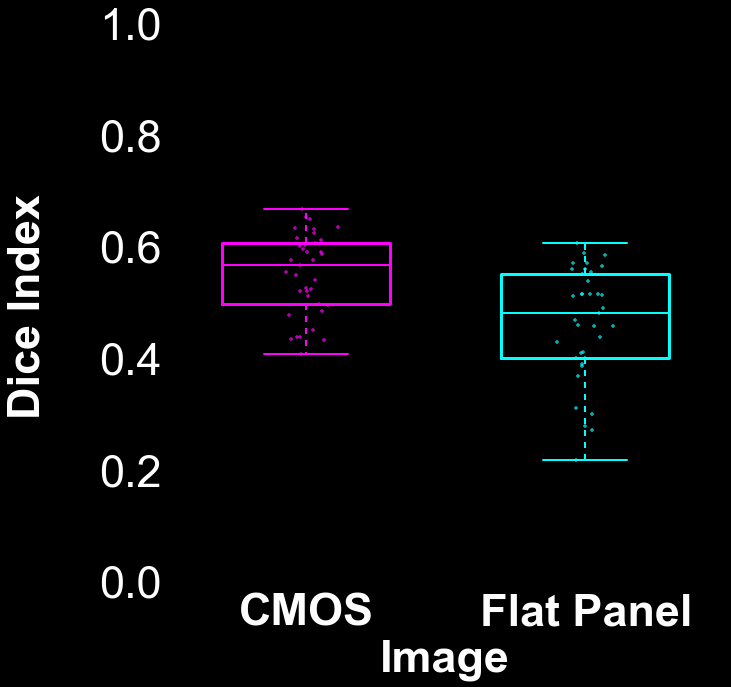

In [262]:
import copy
#transparent=True
datamatrix = pd.read_csv(resultFile,index_col=0)

graphResultFolder = r'J:\Projects\JHUTrabeculae\Results\uCTVsCMOSvsFlatpanel\ResultGraphs'



Dice = [datamatrix[(datamatrix['Image origin'] == 'CMOS')]['Dice'].values,\
        datamatrix[(datamatrix['Image origin'] == 'FlatPanel')]['Dice'].values]

Jaccard = [ datamatrix[(datamatrix['Image origin'] == 'CMOS')]['Jaccard'].values,\
            datamatrix[(datamatrix['Image origin'] == 'FlatPanel')]['Jaccard'].values]


color = 'yellow'
fontsize = 45

colors = ['magenta', 'cyan']
colors2 = ['magenta', 'magenta','cyan', 'cyan']



fig = plt.figure(figsize=(10, 10), facecolor='black')
ax = fig.add_subplot(111, axisbg='black')


bp = ax.boxplot(Dice, widths=[0.6,0.6])
for i in range(2):
    print i, np.mean(Dice[i])
    x = np.random.normal(i+1,0.04,size=len(Dice[i]))
    ax.plot(x,Dice[i],'k.', alpha=0.7,color = colors[i])


ax.set_axisbelow(True)




ax.tick_params(axis='x', labelsize=fontsize, color = 'white')
ax.tick_params(axis='y', labelsize=fontsize, color = 'white')

ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

ax.set_xlabel('Image', fontsize=fontsize,fontweight="bold",color = 'white')
ax.set_ylabel('Dice Index' + '\n', fontsize=fontsize,fontweight="bold",color = 'white')
ax.set_title('' + '\n', fontsize=fontsize*1.2,fontweight="bold", color = color)

ax.spines['left'].set_color('white')
ax.spines['bottom'].set_color('white')



ax.grid(b=False)
## change outline color, fill color and linewidth of the boxes



for i , box in enumerate(bp['boxes']):
    # change outline color
    box.set( color=colors[i], linewidth=3)

## change color and linewidth of the whiskers
for i, whisker in enumerate(bp['whiskers']):
    whisker.set(color=colors2[i], linewidth=2)

## change color and linewidth of the caps
for i, cap in enumerate( bp['caps']):
    cap.set(color=colors2[i], linewidth=2)

## change color and linewidth of the medians
for i, median in enumerate(bp['medians']):
    median.set(color=colors[i], linewidth=2)

## change the style of fliers and their fill
for i, flier in enumerate(bp['fliers']):
    flier.set(marker='o', color=colors[i])

ax.set_xticklabels([ 'CMOS', 'Flat Panel'],fontweight="bold")



ax.set_ylim([0,1])


# Save results
resultfile = graphResultFolder + r'/Dice.png'
#resultfile = graphResultFolder + r'/'+varName+'VsRoISize.pdf'
plt.savefig(resultfile,bbox_inches='tight',facecolor=fig.get_facecolor())




0 0.55877556164
1 0.470624874163


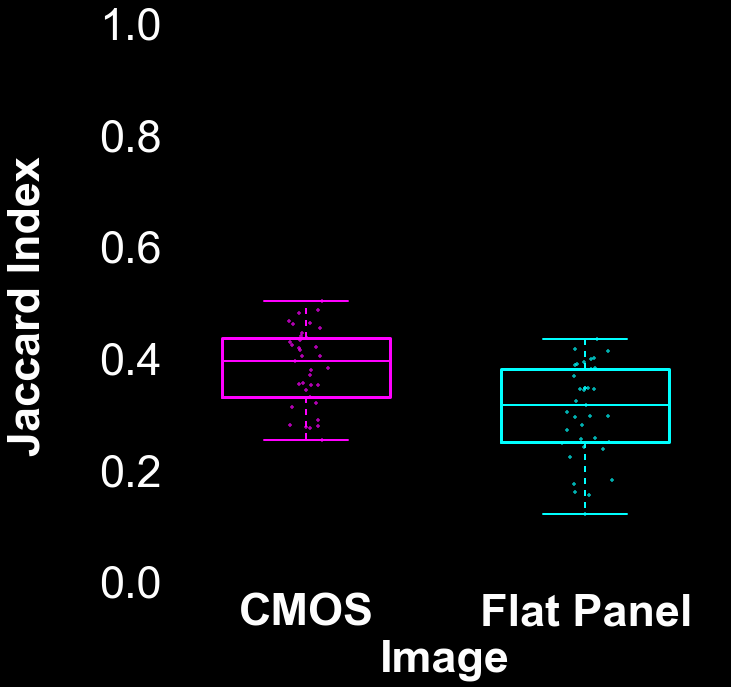

In [259]:


color = 'yellow'
fontsize = 45

colors = ['magenta', 'cyan']
colors2 = ['magenta', 'magenta','cyan', 'cyan']



fig = plt.figure(figsize=(10, 10), facecolor='black')
ax = fig.add_subplot(111, axisbg='black')


bp = ax.boxplot(Jaccard, widths=[0.6,0.6])
for i in range(2):
    print i, np.mean(Dice[i])
    x = np.random.normal(i+1,0.04,size=len(Dice[i]))
    ax.plot(x,Jaccard[i],'k.', alpha=0.7,color = colors[i])


ax.set_axisbelow(True)




ax.tick_params(axis='x', labelsize=fontsize, color = 'white')
ax.tick_params(axis='y', labelsize=fontsize, color = 'white')

ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

ax.set_xlabel('Image', fontsize=fontsize,fontweight="bold",color = 'white')
ax.set_ylabel('Jaccard Index' + '\n', fontsize=fontsize,fontweight="bold",color = 'white')
ax.set_title('' + '\n', fontsize=fontsize*1.2,fontweight="bold", color = color)

ax.spines['left'].set_color('white')
ax.spines['bottom'].set_color('white')



ax.grid(b=False)
## change outline color, fill color and linewidth of the boxes



for i , box in enumerate(bp['boxes']):
    # change outline color
    box.set( color=colors[i], linewidth=3)

## change color and linewidth of the whiskers
for i, whisker in enumerate(bp['whiskers']):
    whisker.set(color=colors2[i], linewidth=2)

## change color and linewidth of the caps
for i, cap in enumerate( bp['caps']):
    cap.set(color=colors2[i], linewidth=2)

## change color and linewidth of the medians
for i, median in enumerate(bp['medians']):
    median.set(color=colors[i], linewidth=2)

## change the style of fliers and their fill
for i, flier in enumerate(bp['fliers']):
    flier.set(marker='o', color=colors[i])

ax.set_xticklabels([ 'CMOS', 'Flat Panel'],fontweight="bold")



ax.set_ylim([0,1])

# Save results
resultfile = graphResultFolder + r'/Jaccard.png'
#resultfile = graphResultFolder + r'/'+varName+'VsRoISize.pdf'
plt.savefig(resultfile,bbox_inches='tight',transparent=True)

## 6.4 Print Results uCT Vs RoI localization

## 6.5 Print Results uCT vs CBCT

## 6.6 Print Results uCT vs CBCT# Results for conference

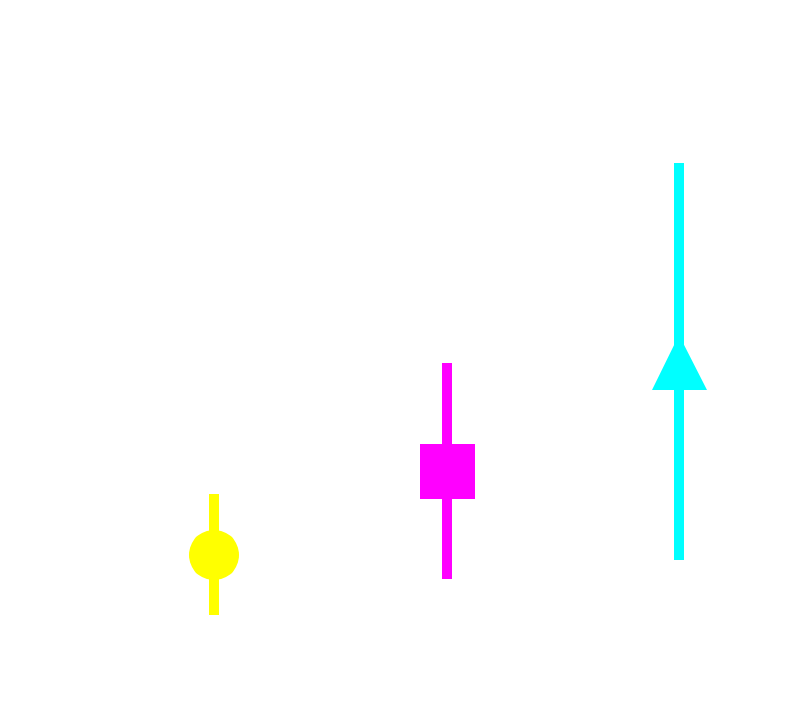

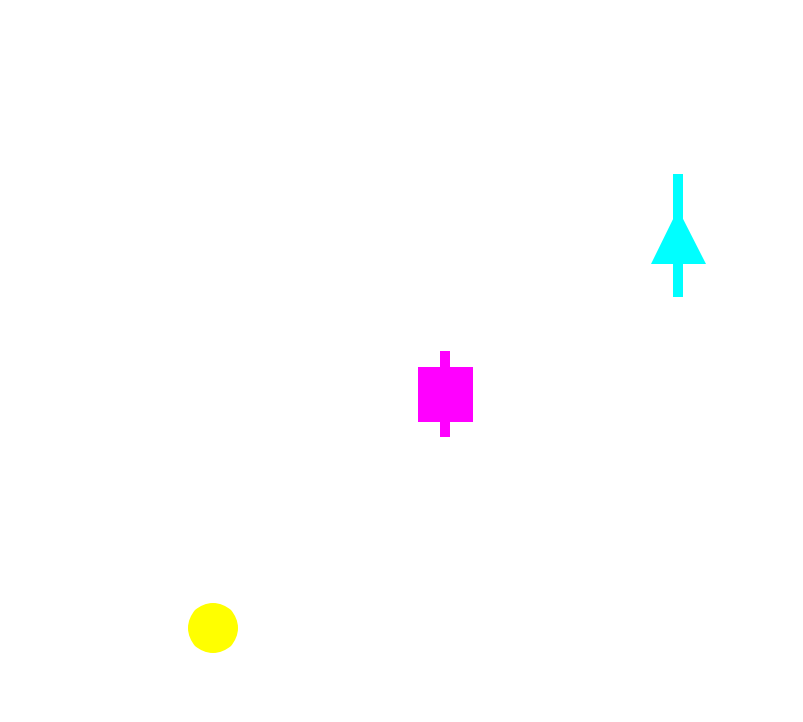

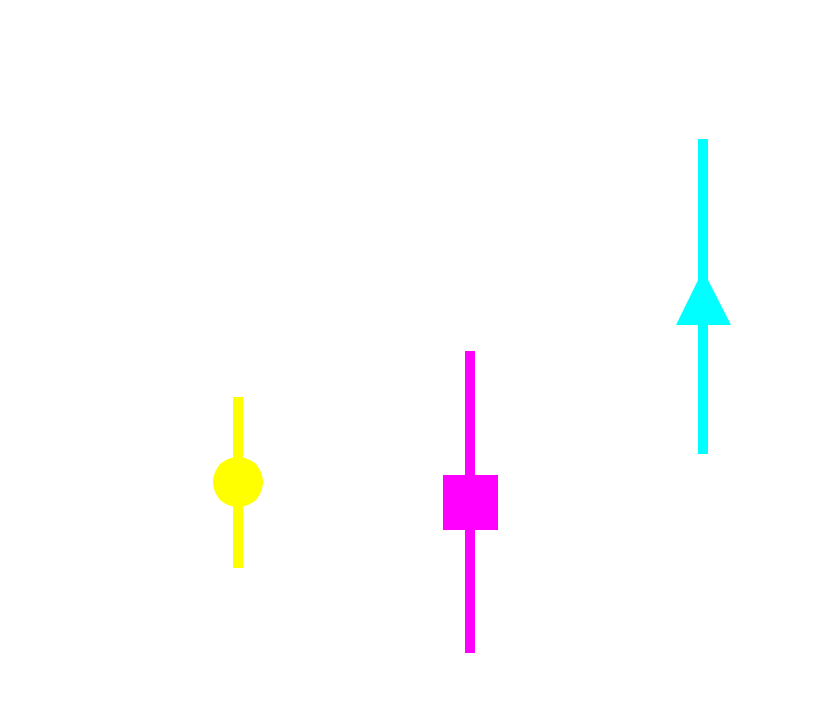

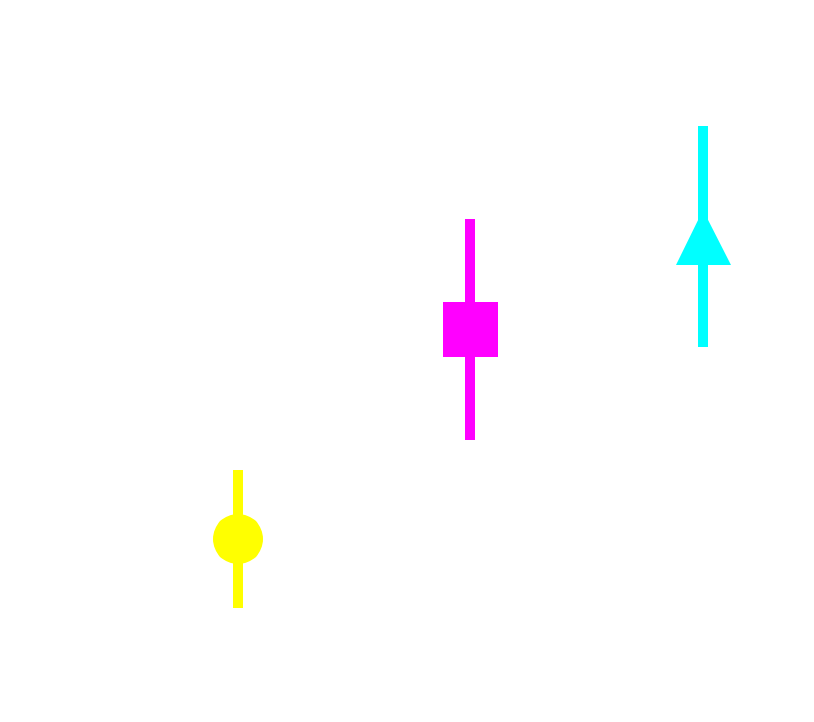

In [268]:
graphResultFolder = r'J:\Projects\JHUTrabeculae\Results\uCTVsCMOSvsFlatpanel\ResultGraphs'

varToShow = [61,64,69,70]

subdata = datamatrix

colors = ['magenta', 'cyan']
colors2 = ['magenta', 'magenta','cyan', 'cyan']

color = 'yellow'
for var in varToShow:
    varName = subdata.columns.values[var]
    
    subdata_uCT = datamatrix[(datamatrix['Image origin'] == 'uCT') & (datamatrix[varName].notnull())]
    subdata_CMOS = datamatrix[(datamatrix['Image origin'] == 'CMOS') &(datamatrix[varName].notnull())]
    subdata_CMOS = subdata_CMOS[(subdata_CMOS['Dice'].values > np.percentile(subdata_CMOS['Dice'].values,25))]
    
    subdata_FlatPanel = datamatrix[(datamatrix['Image origin'] == 'FlatPanel')& (datamatrix[varName].notnull())]
    subdata_FlatPanel = subdata_FlatPanel[(subdata_FlatPanel['Dice'].values > np.percentile(subdata_FlatPanel['Dice'].values,25))]
    
    
    RoINumbers = subdata_uCT['RoI Number'].values.astype(int)

    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    ax.errorbar(0,subdata_uCT[varName].values.mean(),yerr=subdata_uCT[varName].values.std(),  c=color, marker='o', markersize = 50, ls = '--', elinewidth=10)
    ax.errorbar(1,subdata_CMOS[varName].values.mean(),yerr=subdata_CMOS[varName].values.std(),  c='magenta', marker='s', markersize = 55, elinewidth=10)
    ax.errorbar(2,subdata_FlatPanel[varName].values.mean(),yerr=subdata_FlatPanel[varName].values.std(),  c='cyan', marker='^', markersize = 55, elinewidth=10)
    
    
    
    plt.xticks([0,1,2], ['uCT','CMOS', 'Flat Panel'],fontweight="bold")
    ax.set_xlabel('', fontsize=27,fontweight="bold",color = 'white')
    ax.set_ylabel(varName + '\n', fontsize=fontsize,fontweight="bold",color = 'white')
    ax.set_axis_bgcolor('white')
    ax.tick_params(axis='x', labelsize=fontsize, color = 'white')
    ax.tick_params(axis='y', labelsize=fontsize, color = 'white')
    ax.set_xlim([-0.2,2.2])
    #ax.set_ylim(limY)
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.set_title(varName + '\n', fontsize=fontsize*1.2,fontweight="bold", color = 'white')
    ax.grid(b=False)

    
    # Save results
    resultfile = graphResultFolder + r'/'+varName+'Metric_yellow.png'
    #resultfile = graphResultFolder + r'/'+varName+'VsRoISize.pdf'
    plt.savefig(resultfile,bbox_inches='tight',transparent=True)

C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from IPython.kernel.zmq import kernelapp as app


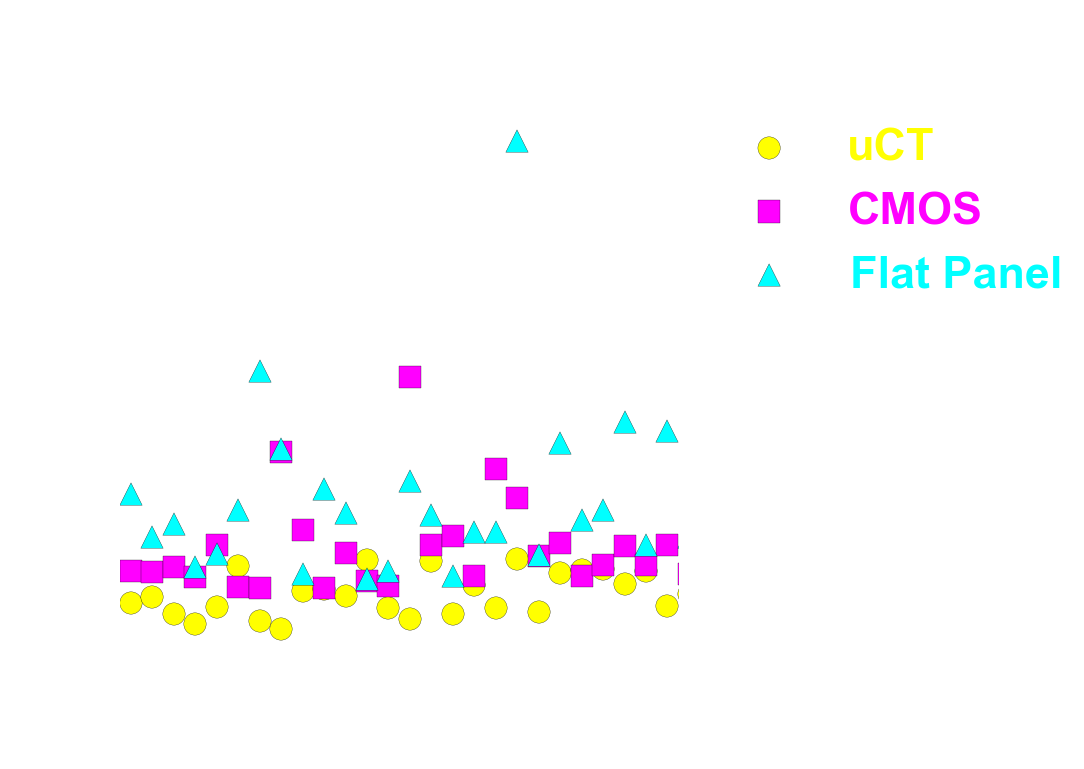

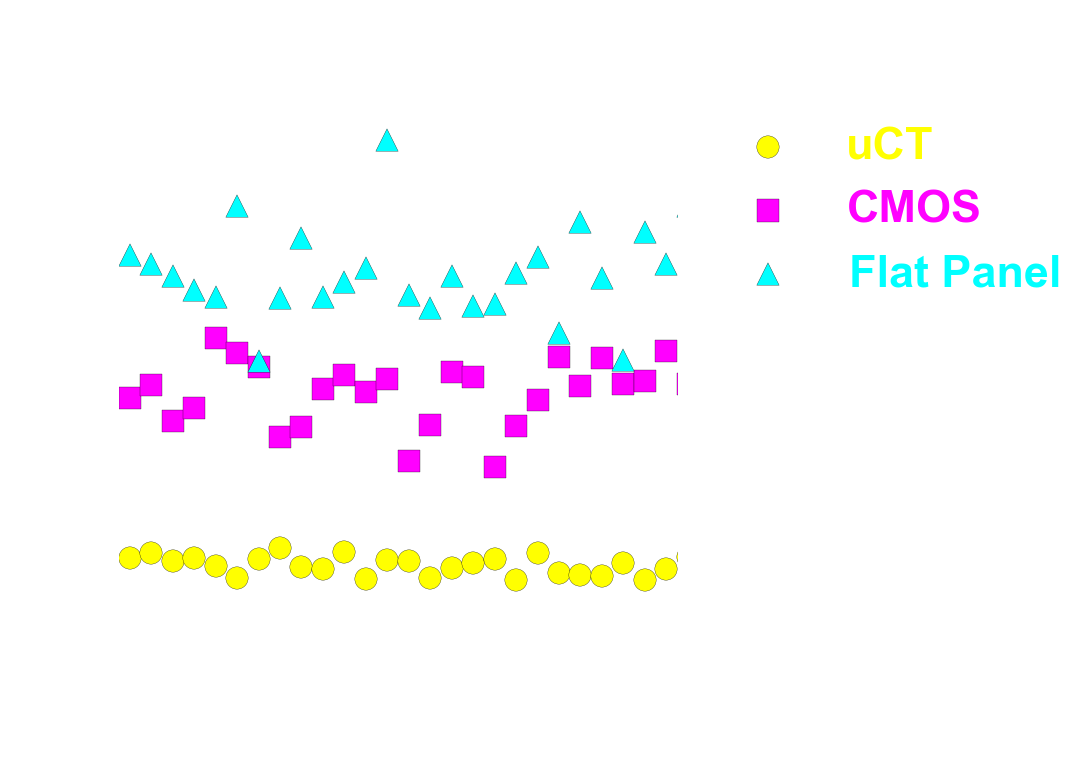

In [269]:

datamatrix.sort(columns = 'RoI Number')

varToShow = [61,64]

datamatrix2 = datamatrix[(datamatrix['RoI Number'] == 20) |\
                         (datamatrix['RoI Number'] == 23) |\
                         (datamatrix['RoI Number'] == 24) |\
                         (datamatrix['RoI Number'] == 25) |\
                         (datamatrix['RoI Number'] == 26) |\
                         (datamatrix['RoI Number'] == 29) |\
                         (datamatrix['RoI Number'] == 2)  |\
                         (datamatrix['RoI Number'] == 30)  |\
                         (datamatrix['RoI Number'] == 31) |\
                         (datamatrix['RoI Number'] == 32) |\
                         (datamatrix['RoI Number'] == 34) |\
                         (datamatrix['RoI Number'] == 35) |\
                         (datamatrix['RoI Number'] == 36) |\
                         (datamatrix['RoI Number'] == 37) |\
                         (datamatrix['RoI Number'] == 38) |\
                         (datamatrix['RoI Number'] == 39) |\
                         (datamatrix['RoI Number'] == 40) |\
                         (datamatrix['RoI Number'] == 42) |\
                         (datamatrix['RoI Number'] == 45) |\
                         (datamatrix['RoI Number'] == 46) |\
                         (datamatrix['RoI Number'] == 49) |\
                         (datamatrix['RoI Number'] == 4) |\
                         (datamatrix['RoI Number'] == 50) |\
                         (datamatrix['RoI Number'] == 52) |\
                         (datamatrix['RoI Number'] == 5) |\
                         (datamatrix['RoI Number'] == 8) |\
                         (datamatrix['RoI Number'] == 9) ]



color = 'yellow'
fontsize = 45
for var in varToShow:
    varName = subdata.columns.values[var]
    
    subdata_uCT = datamatrix2[(datamatrix2['Image origin'] == 'uCT') & (datamatrix2[varName].notnull())]
    
    meanValues = list()
    for name, g in subdata_uCT.groupby(['RoI Number']):
        meanValues.append(np.mean(g[varName].values))
    
    
    subdata_CMOS = datamatrix[(datamatrix['Image origin'] == 'CMOS') &(datamatrix[varName].notnull())]
    subdata_CMOS = subdata_CMOS[(subdata_CMOS['Dice'].values > np.percentile(subdata_CMOS['Dice'].values,25))]
    
    subdata_FlatPanel = datamatrix[(datamatrix['Image origin'] == 'FlatPanel')& (datamatrix[varName].notnull())]
    subdata_FlatPanel = subdata_FlatPanel[(subdata_FlatPanel['Dice'].values > np.percentile(subdata_FlatPanel['Dice'].values,25))]
    
    
    RoINumbers = range(len(subdata_CMOS['RoI Number'].values.astype(int)))
       
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    ax.scatter(RoINumbers,meanValues, c=color,  marker='o', s = 500)
    ax.scatter(RoINumbers,subdata_CMOS[varName].values,  c='magenta', s = 500, marker='s')
    ax.scatter(RoINumbers,subdata_FlatPanel[varName].values,  c='cyan', s = 500, marker='^')
    
    
    ax.set_xlabel('RoI Id', fontsize=fontsize,fontweight="bold", color = 'white')
    ax.set_ylabel(varName, fontsize=fontsize,fontweight="bold", color = 'white')
    ax.set_title(varName + '\n', fontsize=fontsize*1.2,fontweight="bold", color = 'white')
    ax.set_axis_bgcolor('white')
    ax.tick_params(axis='x', labelsize=fontsize, color = 'white')
    ax.tick_params(axis='y', labelsize=fontsize, color = 'white')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.set_xlim([-0.5,25.5])
    leg = ax.legend(bbox_to_anchor=(1.05,1),labels=['uCT','CMOS', 'Flat Panel'], fontsize=fontsize, loc=2, borderaxespad=0.)
    ax.grid(b=False)
    
    colors = ['yellow','magenta', 'cyan']
    for i, text in enumerate(leg.get_texts()):
        text.set_color(colors[i])
        text.set_weight('bold')
    
    #(labels=['MDCT','uCT'])
    
    # Save results
    resultfile = graphResultFolder + r'/'+varName+'_VsRoINumber_line_yellow.png'
    #resultfile = graphResultFolder + r'/'+varName+'VsRoISize.pdf'
    plt.savefig(resultfile,bbox_inches='tight',transparent=True)

In [ ]:
: